# Stable Tautomers

In [1]:
import os, sys
root = os.path.dirname(os.path.dirname(os.path.abspath("__file__")))

import Auto3D
print(Auto3D.__version__)
from Auto3D.auto3D import options
from Auto3D.tautomer import get_stable_tautomers

from rdkit import Chem
from rdkit.Chem import Draw

2.2.6


## 1. Method

Low-energy tautomers are identified using the following steps:
1. Enumerate reasonable tautomers for each input SMILES;
2. Get top `k` conformers for each tautomer;
4. Group all conformers of all tautomers of the same SMILES together (shaded in yellow), select the top `tauto_k` conformers as the final stable tautomer 3D structures for the input SMILES.

Please note the difference between two arguments: `k` and `tauto_k` (The difference between `window` and `tauto_window` are similar). The following figure demonstrate the difference between `k` and `tauto_k`.

<figure>
    <img src="./files/tauto_k.png">
    <figcaption>"k" is used to select conformers in the blue area; "tauto_k" is used to select the conformers in the yellow area. </figcaption>
</figure>

## 2. Example: Get Tautomers Using the Python Library Interface

Since the tautomers are ranked based on their conformer energies, the 1st step is to generate conformers for all tautomers.

The conformer generation step sets `max_confs=10` and `patience=200`. Because here we care more about the relative stabilities of tautomers, 10 conformers from each tautomer would be a good representation whereas maintaining high efficiency. You need to set `max_confs` and `patience` to larger values to get more precise energy difference between tautomers. 

`get_stable_tautomer` function directly accepts the arguments from the `options` function. In addition, `get_stable_tautomer` also needs either `tatuo_k` or `tauto_window` for tautomer selection. The tautomers are saved in the output SDF file. Internally, the `get_stable_tautomer` function calls the `main` function to get 3D conformers and then selecte stable tautomers.

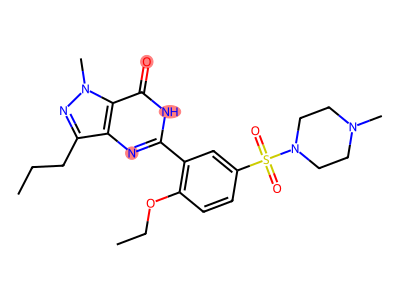

In [2]:
# Let's look at the molecule that we are going to investigate
# We want to know the relative stability of tautomers of this molecule
input_path = os.path.join(root, "example", "files", "sildnafil.smi")
mol = next(Chem.SmilesMolSupplier(input_path, titleLine=False))
mol.__sssAtoms = [8, 9, 10, 11, 12]
Draw.MolToImage(mol, size=(400, 300), highlightAtoms=[8, 10, 12])
# Note the highlighted atoms (N, N, O), this is where the proton transfer happens.

In [3]:
# Get the 3D conformers for input SMILES
if __name__ == "__main__":
    args = options(input_path, k=1, enumerate_tautomer=True, tauto_engine="rdkit",
                   optimizing_engine="ANI2xt",  #ANI2xt is NNP designed for tautomers
                   max_confs=10, patience=200, use_gpu=False)
    tautomer_out = get_stable_tautomers(args, tauto_k=3)

Checking input file...
	There are 1 SMILES in the input file /Users/liu5/Documents/Auto3D_pkg/example/files/sildnafil.smi. 
	All SMILES and IDs are valid.
Suggestions for choosing isomer_engine and optimizing_engine: 
	Isomer engine options: RDKit and Omega.
	Optimizing engine options: ANI2x, ANI2xt and AIMNET.
The available memory is 16 GB.
The task will be divided into 1 jobs.
Job1, number of inputs: 1


Isomer generation for job1
Enumerating tautomers for the input...Tautomers are saved in /Users/liu5/Documents/Auto3D_pkg/example/files/20231220-114536-371822_sildnafil/job1/smi_taut.smi
Enumerating cis/tran isomers for unspecified double bonds...
Enumerating R/S isomers for unspecified atomic centers...
Removing enantiomers...
Enumerating conformers/rotamers, removing duplicates...


100%|██████████| 3/3 [00:00<00:00,  4.15it/s]
/Users/liu5/miniforge3/envs/py39/lib/python3.9/site-packages/torchani/utils.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self_energies = torch.tensor(self_energies, dtype=torch.double)




Optimizing on job1
Preparing for parallel optimizing... (Max optimization steps: 5000)
Total 3D conformers: 30


 10%|▉         | 499/5000 [01:14<09:56,  7.54it/s]

Total 3D structures: 30  Converged: 0   Dropped(Oscillating): 8    Active: 22


 20%|██        | 1001/5000 [01:51<02:55, 22.74it/s]

Total 3D structures: 30  Converged: 3   Dropped(Oscillating): 18    Active: 9


 30%|███       | 1504/5000 [02:06<01:24, 41.23it/s]

Total 3D structures: 30  Converged: 5   Dropped(Oscillating): 21    Active: 4


 40%|███▉      | 1995/5000 [02:18<01:03, 47.35it/s]

Total 3D structures: 30  Converged: 6   Dropped(Oscillating): 21    Active: 3


 44%|████▎     | 2182/5000 [02:21<03:03, 15.37it/s]


Optimization finished at step 2183:   Total 3D structures: 30  Converged: 9   Dropped(Oscillating): 21    Active: 0
Begin to select structures that satisfy the requirements...
Energy unit: Hartree if implicit.
Program running time: 3 minute(s)
Output path: /Users/liu5/Documents/Auto3D_pkg/example/files/20231220-114536-371822_sildnafil/sildnafil_out.sdf

Begin to select stable tautomers based on their conformer energies...
Done.
The stable tautomers are stored in: /Users/liu5/Documents/Auto3D_pkg/example/files/20231220-114536-371822_sildnafil/sildnafil_out_top_tautomers.sdf


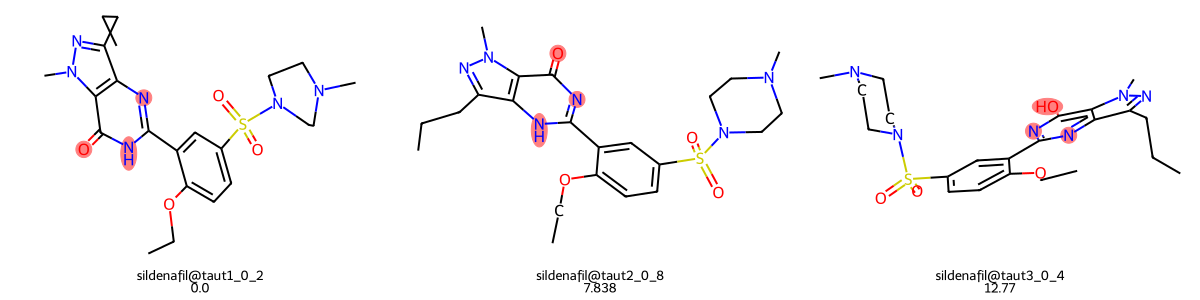

In [4]:
# visualize the tautomers for sildnafil and their relative energies
tautomers = list(Chem.SDMolSupplier(tautomer_out))
ids = [mol.GetProp('ID') for mol in tautomers]
relative_es = [mol.GetProp('E_tautomer_relative(kcal/mol)') for mol in tautomers]
legends = [ids[i] + '\n' + relative_es[i][:5] for i in range(len(tautomers))]

Draw.MolsToGridImage(tautomers, legends=legends, subImgSize=(400, 300), highlightAtomLists=[[9, 10, 31] for _ in range(3)])
# the following is a projection of 3D tautomers into a 2D figure

We can see the relative stability of the tautomers of sildnafil.

## 3. Example: Get Tautomers Using a yaml File

The following CLI gives the same output as the previous examples.
```
python tauto_interface.py tauto.yaml
```
All related parameters are saved in the `tauto.yaml`. Example of  `tauto_interface.py` and `tauto.yaml` files can be found on GitHub.

## 4. Example: Get Tautomers Using the Command Line Interface (CLI)

The following CLI gives the same output as the previous examples.
```
python tauto_interface.py <your_smi_path> --k=1 --enumerate_tautomer=True --tauto_engine="rdkit" --max_confs=10 --patience=200 --use_gpu=False --tauto_k=1 
```
Example `tauto_interface.py` can be found on the project Github.